In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from swdb_2018_neuropixels.ephys_nwb_adapter import NWB_adapter    

In [6]:
drive_path = '/data/dynamic-brain-workshop/visual_coding_neuropixels'

In [7]:
manifest_file = os.path.join(drive_path,'ephys_manifest.csv')
expt_info_df = pd.read_csv(manifest_file)
multi_probe_expt_info = expt_info_df[expt_info_df.experiment_type == 'multi_probe']
multi_probe_example = 1 # index to row in multi_probe_expt_info
multi_probe_filename  = multi_probe_expt_info.iloc[multi_probe_example]['nwb_filename']
nwb_file = os.path.join(drive_path,multi_probe_filename)
data_set = NWB_adapter(nwb_file)

In [8]:
from downsampling_module import downsample_images

In [9]:
nat_scenes = np.load('natural_scenes.npy')

In [10]:
ds_nat_scenes = np.array(downsample_images(nat_scenes, 25, 25))
ds_nat_scenes = ds_nat_scenes*(1.0/255.0)

(118, 36, 46)


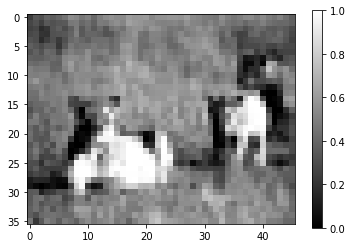

In [11]:
print(ds_nat_scenes.shape)
plt.imshow(ds_nat_scenes[7], cmap='gray')
plt.colorbar()

In [12]:
from downsampling_module import flatten_images

In [13]:
flattened_image_list = flatten_images(np.array(ds_nat_scenes))

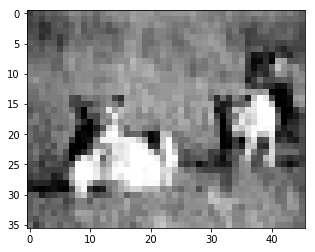

In [14]:
plt.imshow(flattened_image_list[7].reshape(36,46), cmap='gray')

In [15]:
stim_table = data_set.get_stimulus_table('natural_scenes')

In [16]:
def get_frame_at_time(time, stim_table):
    starts = stim_table.start.values
    idx = np.searchsorted(starts, time)-1
    return(stim_table.iloc[idx].values[2])

In [17]:
def get_stim_time_array(stim_table, tns_start, tns_end, bin_len, flattened_image_list):
    T = int(np.floor((tns_end - tns_start)/bin_len))
    time_array = np.linspace(tns_start,tns_end,T)
    stim_array = []
    for idx, time_point in enumerate(time_array):
        stim_index = get_frame_at_time(time_point, stim_table)
        stim_array.append(flattened_image_list[int(stim_index)])
    return(stim_array, time_array)

# def get_stim_time_arrays_imgs(stim_table, bin_len, flattened_image_list, imgs, nums):
#     time_arrays = []
#     stim_arrays = []
#     for num in nums:
#         stim_array = []
#         for img in imgs:
#             for i in range(num):   
    

(112,)


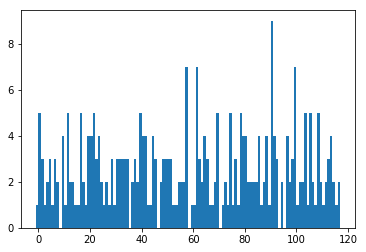

In [92]:
print np.unique(stim_table.frame.values[:300]).shape
a = plt.hist(stim_table.frame.values[:300],bins=118)

In [19]:
bin_len = 0.001
num_stim_rows = 300
imgs = np.unique(stim_table.frame.values[:num_stim_rows])
print len(imgs)
tns_start = stim_table.iloc[0].values[0]
tns_end = stim_table.iloc[num_stim_rows].values[1]
print(tns_start)
print(tns_end)

112
5908.725920000001
5984.037139999999


In [20]:
[stim_array, time_array] = get_stim_time_array(stim_table,tns_start,tns_end,bin_len,flattened_image_list)
print(tns_start)
print(tns_end)

5908.725920000001
5984.037139999999


In [21]:
print(np.shape(stim_array))

print(np.shape(time_array))


(75311, 1656)
(75311,)


In [22]:
# print(time_array.shape)
# print(np.array(stim_array).shape)

# time_array_short = time_array[0:len(time_array)/4]
# stim_array_short = stim_array[:,:len(time_array)/4]
# print(time_array_short.shape)
# print(np.array(stim_array_short).shape)

tns_start = time_array[0]
tns_end = time_array[-1]
print(tns_start)
print(tns_end)

print(time_array.shape)


5908.725920000001
5984.037139999999
(75311,)


In [23]:
def bin_spikes(data_set,bin_len,t_start,t_final,probes=None,regions=None):
    if probes is None:
        probes = data_set.probe_list
    if regions is None:
        regions = data_set.unit_df.structure.unique()
    
    #gather cells from desired regions and probes into cell_table
    use_cells = False
    for probe in probes:
        for region in regions:
            use_cells |= (data_set.unit_df.probe==probe) & (data_set.unit_df.structure==region)
    cell_table = data_set.unit_df[use_cells]
    
    N = len(cell_table)     #number of cells
    T = int(np.floor((t_final-t_start)/bin_len)) #number of time bins
    binned_spikes = np.zeros((N,T)) # binned_spikes[i,j] is the number of spikes from neuron i in time bin j

    #for each cell in the table, add each spike to the appropriate bin
    i = 0
    for z,cell in cell_table.iterrows(): 
        for spike_time in data_set.spike_times[cell['probe']][cell['unit_id']]:
            t = int(np.floor((spike_time-t_start)/bin_len))
            if (t >=0) & (t<T):
                binned_spikes[i,t] += 1
        i+=1    
    return (binned_spikes, cell_table)

In [24]:
(binned_spikes, cell_table) = bin_spikes(data_set,bin_len,tns_start,tns_end,regions=['VISp'])

In [25]:
binned_spikes.shape

(71, 75311)

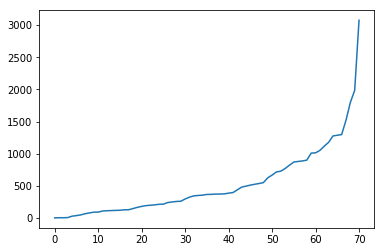

In [26]:
k = 25
cell_idxs = np.argsort(binned_spikes.sum(axis=1))
reduced_binned_spikes = binned_spikes[cell_idxs[-k:],:]
plt.plot(binned_spikes.sum(axis=1)[cell_idxs])

In [27]:
reduced_binned_spikes.shape

(25, 75311)

In [48]:
def construct_GLM_mat(flat_stimulus, binned_spikes, d_stim, d_spk):
    (N,T) = binned_spikes.shape # N is number of neurons, T is number of time bins
#     print("N,T", (N,T))
    (M,T) = flat_stimulus.shape # M is the size of a stimulus
#     print("M,T", (M,T))
    X_dsn = np.empty((T-d_stim,M*d_stim+N*d_spk))
    d_max = max(d_stim,d_spk)
    for t in range(T-d_max):
        X_dsn[t,:M*d_stim] = np.fliplr(flat_stimulus[:,t+d_max-d_stim:t+d_max]).reshape((1,-1))  #stimulus inputs
        X_dsn[t,M*d_stim:] = np.fliplr(binned_spikes[:,t+d_max-d_spk:t+d_max]).reshape((1,-1)) #spike inputs
    return X_dsn    


In [29]:
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras import Sequential
from keras.layers import Dense, Lambda
from keras.regularizers import Regularizer
from keras.callbacks import ModelCheckpoint
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

def GLM_network_fit(stimulus,spikes,d_stim, d_spk,bin_len,f='exp',priors=None,L1=None):
    N = spikes.shape[0]
#     print("N", N)
    M = stimulus.shape[0]
#     print("M", M)
    F = np.empty((N,M,d_stim)) # stimulus filters
    W = np.empty((N,N,d_spk))  # spike train filters
    b = np.empty((N,)) # biases
    losses = np.empty((N,))
    models = []
    fs = {'exp':K.exp}
    Xdsn = construct_GLM_mat(stimulus,spikes, d_stim, d_spk)
    for i in range(N):
        y = spikes[i,max(d_stim,d_spk):]
        # construct GLM model and return fit
        model = Sequential()
        model.add(Dense(1,input_dim = Xdsn.shape[1],use_bias=True))
        model.add(Lambda(lambda x: fs[f](x)*bin_len))
        model.compile(loss = 'poisson',optimizer = keras.optimizers.adam(lr=5e-5))
#        checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=False)
        model.fit(x=Xdsn,y=y,batch_size=5000,epochs=6,verbose=2)
        p = model.get_weights()[0]
        F[i,:,:] = p[:M*d_stim].reshape((M,d_stim))
        W[i,:,:] = p[M*d_stim:].reshape((N,d_spk))
        b[i] = model.get_weights()[1]
#         losses[i] = model.evaluate(x=Xdsn,y=y,verbose=0)
        models.append(model)
    return (F,W,b,losses,models)


In [30]:
d = 40
(F, W, b, losses, models) = GLM_network_fit(np.array(stim_array).T,reduced_binned_spikes,d,d, bin_len)

Epoch 1/6
 - 54s - loss: 0.0421
Epoch 2/6
 - 55s - loss: 0.0422
Epoch 3/6
 - 55s - loss: 0.0420
Epoch 4/6
 - 56s - loss: 0.0424
Epoch 5/6
 - 54s - loss: 0.0415
Epoch 6/6
 - 54s - loss: 0.0415
Epoch 1/6
 - 56s - loss: 0.0444
Epoch 2/6
 - 54s - loss: 0.0426
Epoch 3/6
 - 54s - loss: 0.0426
Epoch 4/6
 - 54s - loss: 0.0427
Epoch 5/6
 - 54s - loss: 0.0424
Epoch 6/6
 - 55s - loss: 0.0422
Epoch 1/6
 - 55s - loss: 0.0450
Epoch 2/6
 - 54s - loss: 0.0442
Epoch 3/6
 - 54s - loss: 0.0441
Epoch 4/6
 - 57s - loss: 0.0434
Epoch 5/6
 - 54s - loss: 0.0433
Epoch 6/6
 - 54s - loss: 0.0439
Epoch 1/6
 - 57s - loss: 0.0504
Epoch 2/6
 - 54s - loss: 0.0491
Epoch 3/6
 - 54s - loss: 0.0478
Epoch 4/6
 - 55s - loss: 0.0479
Epoch 5/6
 - 55s - loss: 0.0477
Epoch 6/6
 - 55s - loss: 0.0472
Epoch 1/6
 - 53s - loss: 0.0524
Epoch 2/6
 - 54s - loss: 0.0511
Epoch 3/6
 - 54s - loss: 0.0512
Epoch 4/6
 - 54s - loss: 0.0509
Epoch 5/6
 - 54s - loss: 0.0512
Epoch 6/6
 - 56s - loss: 0.0505
Epoch 1/6
 - 53s - loss: 0.0564
Epoch 2/

In [32]:
np.savez('net_fit1',F=F,W=W,b=b,losses=losses)

In [99]:
print len(stim_table[(stim_table.frame==img_inds[-2])&(stim_table.index>=num_stim_rows)])

43


In [100]:
def evaluate_network(stimulus,spikes, d_stim, d_spk, models):
    N = spikes.shape[0]
    loss = 0
    Xdsn = construct_GLM_mat(stimulus,spikes, d_stim, d_spk)
    for i in range(N):
        y = spikes[i,max(d_stim,d_spk):]
        loss += models[i].evaluate(x=Xdsn, y=y, batch_size = 100000000, verbose=0)
    return loss

val_per_img = 40
num_correct = 0
n_img_val = 2
img_inds = np.argsort(np.bincount(stim_table[stim_table.frame>=0].frame.values[:num_stim_rows].astype(int)))[-n_img_val:]
for img in imgs[img_inds]:
    for i in range(val_per_img):
        t_start = stim_table[(stim_table.index>num_stim_rows) & (stim_table.frame==img)].start.values[i]
        t_end = stim_table[(stim_table.index>num_stim_rows) & (stim_table.frame==img)].end.values[i]
        (binned_spikes, _) = bin_spikes(data_set,bin_len,t_start,t_end,regions=['VISp'])
        reduced_binned_spikes = binned_spikes[cell_idxs[-k:],:]
        T = reduced_binned_spikes.shape[1]
        losses = []
        for check_img in imgs[img_inds]:
            flat_stimulus = np.tile(np.expand_dims(flattened_image_list[int(check_img)],1),(1,T)) #flatten check_img for the right number of time points
            losses.append(evaluate_network(flat_stimulus,reduced_binned_spikes,d,d,models))
        if imgs[img_inds[np.argmin(losses)]] == img:
            num_correct += 1
accuracy = num_correct*1.0/(val_per_img*n_img_val)
print accuracy

0.8125


In [94]:
# from keras.regularizers import Regularizer
# from keras import backend as K

# class SparseGroupLasso(Regularizer):
#     """Regularizer for group lasso regularization.
#     # Arguments
#        l1: Float; L1 regularization factor.
#        l2: Float; L2 group regularization factor.
#    """

#     def __init__(self, size_stim, d_spike, lgroup = 1.):
#         self.lgroup = K.cast_to_floatx(lgroup)
#         self.d_spike = d_spike
#         self.size_stim = size_stim

#     def __call__(self, x): 
#         xr = K.reshape(x[self.size_stim:], (-1, self.d_spike))
#         print("xrshape", xr.shape)
#         return(self.lgroup * np.sqrt(K.int_shape(xr)[1])*K.sum(K.sqrt(K.sum(K.square(xr),axis=1))))
    
# from keras.regularizers import Regularizer
# from keras import backend as K



class GroupAndPriors(Regularizer):
    """Regularizer for group lasso regularization.
    # Arguments
       l1: Float; L1 regularization factor.
       l2: Float; L2 group regularization factor.
   """

    def __init__(self, size_stim, d_spike, priors = None, lprior = 0, lgroup = 0.):
        self.lgroup = K.cast_to_floatx(lgroup)
        if priors is not None:
            self.lprior = K.cast_to_floatx(lprior)
            self.W_means = priors['W_means']
            self.W_vars = priors['W_vars']
            self.W_weights = priors['W_weights']
            
        else:
            self.lprior = 0
            
        self.d_spike = d_spike
        self.size_stim = size_stim

    def __call__(self, x): 
        xr = K.reshape(x[self.size_stim:], (-1, self.d_spike))
        pen = 0.
        if self.lgroup > 0:
            pen += self.lgroup * np.sqrt(K.int_shape(xr)[1])*K.sum(K.sqrt(K.sum(K.square(xr),axis=1)))
        if self.lprior > 0:
            pen += self.lprior * K.sum(K.log(K.sum(self.W_weights*K.exp(-0.5*K.square(xr-self.W_means)/self.W_vars),axis=0)),axis=1)
        return pen



In [ ]:
import h5py

In [ ]:
hf = h5py.File('weights.hdf5', 'r')

In [ ]:
hf['model_weights/dense_4/dense_4'].values()

In [ ]:
W[0].shape

In [ ]:
norms = np.linalg.norm(W[0], axis = 1)

In [ ]:
norms.shape

In [ ]:
plt.hist(norms, bins = 50);

In [ ]:
filter = W[0,5,:]
plt.plot(filter)
print("norm", np.linalg.norm(filter))



In [ ]:
filtermat = W[0,:,:]

In [ ]:
filtermat.shape

In [ ]:
plt.plot(filtermat[:,4])

In [ ]:
plt.hist(np.linalg.norm(filtermat, axis = 0), bins = 10)

In [ ]:
# def construct_GLM_mat(flat_stimulus, binned_spikes, i, d_stim, d_spk):
#     (N,T) = binned_spikes.shape # N is number of neurons, T is number of time bins
#     print("T",T)
#     (M,T) = flat_stimulus.shape # M is the size of a stimulus
#     X_dsn = np.empty((T-d_stim+1,M*d_stim+N*d_spk))
#     d_max = max(d_stim,d_spk)
#     y = np.empty((T-d_max+1,))
#     for t in range(T-d_max+1):
#         y[t] = binned_spikes[i,t+d_max-1]
#         X_dsn[t,:M*d_stim] = flat_stimulus[:,t+d_max-d_stim:t+d_max].reshape((1,-1))
#         X_dsn[t,M*d_stim:] = binned_spikes[:,t+d_max-d_spk:t+d_max].reshape((1,-1))
#     return (y, X_dsn)   

In [ ]:
# import keras
# from keras import backend as K
# from keras.models import Model
# from keras.layers import Input
# from keras import Sequential
# from keras.layers import Dense, Lambda
# from keras.regularizers import Regularizer
# def GLM_network_fit(stimulus,spikes,d_stim, d_spk,bin_len,f='exp',priors=None,L1=None):
#     N = spikes.shape[0]
#     print("N", N)
#     M = stimulus.shape[0]
#     print("M", M)
#     F = np.empty((N,M,d_stim)) # stimulus filters
#     W = np.empty((N,N,d_spk))  # spike train filters
#     b = np.empty((N,)) # biases
#     fs = {'exp':K.exp}
#     for i in range(1):
#         [y, Xdsn] = construct_GLM_mat(np.array(stim_array), binned_spikes, i, d_stim, d_spk)
#         print("yshape",y.shape)
#         model = Sequential()
#         model.add(Dense(1,input_dim = Xdsn.shape[1],use_bias=True, kernel_regularizer=SparseGroupLasso(M*d_stim,d_spk,lgroup=1e-10)))
#         model.add(Lambda(lambda x: fs[f](x)*bin_len))
#         model.compile(loss = 'poisson',optimizer = keras.optimizers.adam(lr=5e-1))
#         model.fit(x=Xdsn,y=y,epochs=50, batch_size = 1000,  verbose=1)
#         p = model.get_weights()[0]
#         print("pshape", p.shape)
#         print("Mdstim", M*d_stim)
#         F[i,:,:] = p[:M*d_stim].reshape((M,d_stim))
#         W[i,:,:] = p[M*d_stim:].reshape((N,d_spk))
#         b[i] = model.get_weights()[1]
#     return (F,W,b)
